In [66]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

from pytensor.graph import Apply, Op
from scipy.optimize import approx_fprime

Here, we sampled value of $Y-data$, where $Y$ is the model value and $data$ is the observed value. We then calculated the log-likelihood of the sampled data. We will use this sampled data to interpolate the log-likelihood.

$$loglikehood = -\frac{(y-data)^2}{2\sigma}-log(\sqrt{2\pi})-log(\sigma)$$

To simplify the problem, we assume that the standard deviation of the noise is known and equal to 1. We also assume that the noise is Gaussian. The likelihood of the data given the model is then given by:

We adopted a black box likelihood function, which is a function that takes the data and the model parameters as input and returns the log-likelihood, and do not require gradient. (Thus may occur some problem if we extract the gradient of the log-likelihood function)

In [67]:

sampled_data = np.linspace(-500, 500, 1000)
sampled_log_likelihood = -0.5 * ((sampled_data) / 1) ** 2 - np.log(np.sqrt(2 * np.pi)) - np.log(1)


In [68]:
def interpolate(x0, y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [69]:
def my_model(m, c, x):
    return m * x + c

def my_loglike(m, c, sigma, x, data):
    # Use interpolation to get the log-likelihood
    for param in (m, c, sigma, x, data):
        if not isinstance(param, (float, np.ndarray)):
            raise TypeError(f"Invalid input type to loglike: {type(param)}")
    model = my_model(m, c, x)
    return interpolate(sampled_data, sampled_log_likelihood, model-data) 

In [70]:
import numpy as np

N = 10  
sigma = 1.0  
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4 
ctrue = 3.0 

truemodel = my_model(mtrue, ctrue, x)

# make data
rng = np.random.default_rng(716743)
data = sigma * rng.normal(size=N) + truemodel

In [71]:
class LogLike(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        # Convert inputs to tensor variables
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)
        inputs = [m, c, sigma, x, data]
        outputs = [data.type()]

        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        m, c, sigma, x, data = inputs  
        loglike_eval = my_loglike(m, c, sigma, x, data)
        outputs[0][0] = np.asarray(loglike_eval)

In [72]:
loglike_op = LogLike()

test_out = loglike_op(mtrue, ctrue, sigma, x, data)

In [73]:
pytensor.dprint(test_out, print_type=True)

LogLike [id A] <Vector(float64, shape=(10,))>
 ├─ 0.4 [id B] <Scalar(float64, shape=())>
 ├─ 3.0 [id C] <Scalar(float32, shape=())>
 ├─ 1.0 [id D] <Scalar(float32, shape=())>
 ├─ [0. 1. 2. ... 7. 8. 9.] [id E] <Vector(float64, shape=(10,))>
 └─ [2.3876939 ... .56436476] [id F] <Vector(float64, shape=(10,))>


In [74]:
test_out.eval()

array([-1.1561064 , -1.04418891, -1.46832988, -1.04418891, -1.81042321,
       -1.3957944 , -1.04418891, -1.04418891, -1.78158644, -1.57985932])

In [75]:
def custom_dist_loglike(data, m, c, sigma, x):
    return loglike_op(m, c, sigma, x, data)



with pm.Model() as no_grad_model:
    m = pm.Uniform("m", lower=-10.0, upper=10.0, initval=mtrue)
    c = pm.Uniform("c", lower=-10.0, upper=10.0, initval=ctrue)


    likelihood = pm.CustomDist(
        "likelihood", m, c, sigma, x, observed=data, logp=custom_dist_loglike
    )
    

In [76]:
with no_grad_model:
    idata_no_grad = pm.sample(3000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [m]
>Slice: [c]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.


In [77]:
az.summary(idata_no_grad)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,3.27100,0.58900,2.10300,4.31900,0.01300,0.00900,2026.00000,3569.00000,1.00000
m,0.38800,0.11000,0.18600,0.59900,0.00200,0.00200,2021.00000,3402.00000,1.00000


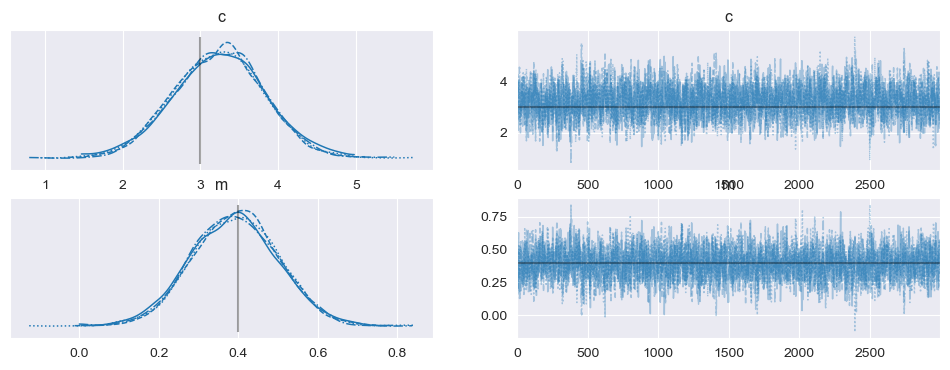

In [13]:
az.plot_trace(idata_no_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);